In [80]:
import sys
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot as plt
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import load_participant_list, get_betamap_paths, Subject

In [60]:
run = 'learning2'
first_level_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/both_modulators_exclude_20250206'

# Load First level data

In [61]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

In [62]:
contrast_modulator_RL_paths, matched_sub_ids = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_beta*_rl.nii.gz")
contrast_modulator_CK_paths, _ = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_beta*_ck.nii.gz")

In [63]:
contrast_modulator_RL_paths[:5]

['/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/both_modulators_exclude_20250206/sub-01/run-learning2/sub-01_run-learning2_beta_first_stim_value_rl.nii.gz',
 '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/both_modulators_exclude_20250206/sub-02/run-learning2/sub-02_run-learning2_beta_first_stim_value_rl.nii.gz',
 '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/both_modulators_exclude_20250206/sub-03/run-learning2/sub-03_run-learning2_beta_first_stim_value_rl.nii.gz',
 '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/both_modulators_exclude_20250206/sub-04/run-learning2/sub-04_run-learning2_beta_first_stim_value_rl.nii.gz',
 '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/both_modulators_exclude_20250206/sub-05/run-learning2/sub-05_run-learning2_beta_first_stim_value_rl.nii.gz']

In [64]:
contrast_modulator_RL_dict = {path: image.load_img(path) for path in contrast_modulator_RL_paths}
contrast_modulator_CK_dict = {path: image.load_img(path) for path in contrast_modulator_CK_paths}

In [65]:
from scipy.stats import pearsonr

correlations = []

for sub_id in matched_sub_ids:
    rl_img = contrast_modulator_RL_dict[contrast_modulator_RL_paths[matched_sub_ids.index(sub_id)]]
    ck_img = contrast_modulator_CK_dict[contrast_modulator_CK_paths[matched_sub_ids.index(sub_id)]]
    
    rl_data = rl_img.get_fdata()
    ck_data = ck_img.get_fdata()
    
    # Flatten the data and remove NaNs
    rl_data_flat = rl_data.flatten()
    ck_data_flat = ck_data.flatten()
    
    valid_mask = ~np.isnan(rl_data_flat) & ~np.isnan(ck_data_flat)
    rl_data_flat = rl_data_flat[valid_mask]
    ck_data_flat = ck_data_flat[valid_mask]
    
    # Compute the correlation
    corr, _ = pearsonr(rl_data_flat, ck_data_flat)
    correlations.append(corr)

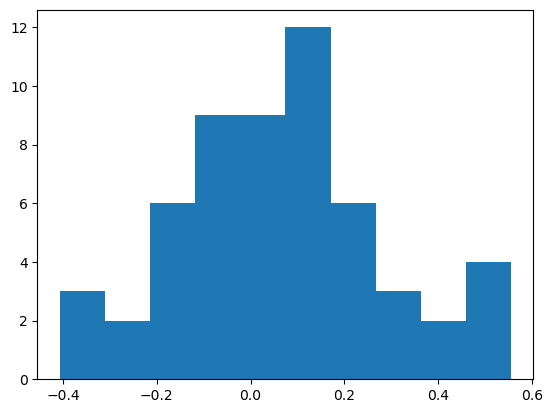

In [66]:
plt.hist(correlations);

# Design matrices

In [67]:
pattern = "sub-{sub_id}_run-{run}_design_matrix.csv"
dm_paths = [glob.glob(os.path.join(first_level_dir, f"sub-{sub_id}", f"run-{run}", 
                                   pattern.format(sub_id=sub_id, run=run)))[0] for sub_id in matched_sub_ids]

In [68]:
DMs = [pd.read_csv(path) for path in dm_paths]

In [69]:
dm_corr = [pearsonr(dm.first_stim_value_rl, dm.first_stim_value_ck)[0] for dm in DMs]

/tmp/ipykernel_100655/1551144771.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  dm_corr = [pearsonr(dm.first_stim_value_rl, dm.first_stim_value_ck)[0] for dm in DMs]


(array([ 2.,  3.,  4.,  4.,  7.,  8.,  7., 10.,  5.,  4.]),
 array([-0.41035724, -0.34746874, -0.28458023, -0.22169173, -0.15880322,
        -0.09591471, -0.03302621,  0.0298623 ,  0.09275081,  0.15563931,
         0.21852782]),
 <BarContainer object of 10 artists>)

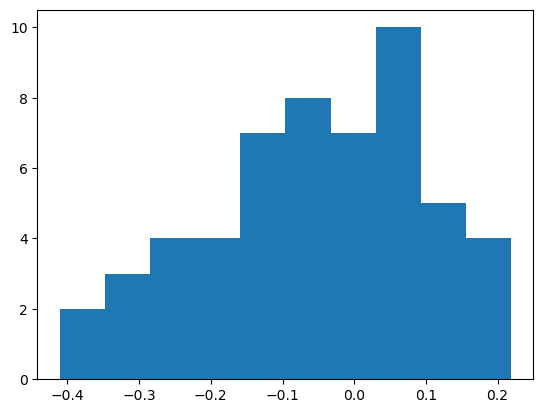

In [105]:
plt.hist(dm_corr)